In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# %%

# Load the dataset
data = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)
data

,raw,temperature,modified1,modified2,modified3
timestamp,,,,,
2021-02-02 00:00:00,0.0,-3.9,0.0,0.0,0.0
2021-02-02 01:00:00,0.0,-3.5,0.0,0.0,0.0
2021-02-02 02:00:00,0.0,-3.0,0.0,0.0,0.0
2021-02-02 03:00:00,0.0,-2.6,0.0,0.0,0.0
2021-02-02 04:00:00,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...
2023-02-01 19:00:00,0.0,0.0,0.0,0.0,0.0
2023-02-01 20:00:00,0.0,0.1,0.0,0.0,0.0
2023-02-01 21:00:00,0.0,0.1,0.0,0.0,0.0


# %% [markdown]

 Since `modified1` has missing values missing completely at random (MCAR), three methods were used to handle the missing data:
 1. **Deletion**: Removed rows with missing values in `modified1`, resulting in a reduced dataset size.
 2. **Univariate Imputation (Median)**: Filled missing values in `modified1` using the median of the column.
 3. **Multivariate Imputation (KNN)**: Imputed `modified1` values based on `temperature`, utilizing relationships between variables.
 Imputation Quality Comparison

In [ ]:
# %%

# Approach 1: Deletion - Remove rows with missing 'modified1'
data_deletion = data.dropna(subset=['modified1']).copy()
print(f"Original data size: {data.shape[0]} rows")
print(f"After deletion: {data_deletion.shape[0]} rows")
print(f"Number of rows removed: {data.shape[0] - data_deletion.shape[0]}")

Original data size: 17016 rows
After deletion: 15825 rows
Number of rows removed: 1191


In [ ]:
# %%

# Approach 2: Univariate Imputation (Median)
median_imputer = SimpleImputer(strategy='median')
data_univariate = data.copy()
data_univariate['modified1'] = median_imputer.fit_transform(
    data_univariate[['modified1']])

In [ ]:
# %%

# Approach 3: Multivariate Imputation (KNN)
knn_imputer = KNNImputer(n_neighbors=5)
data_multivariate = data.copy()
data_multivariate[['modified1', 'temperature']] = knn_imputer.fit_transform(
    data[['modified1', 'temperature']]
)

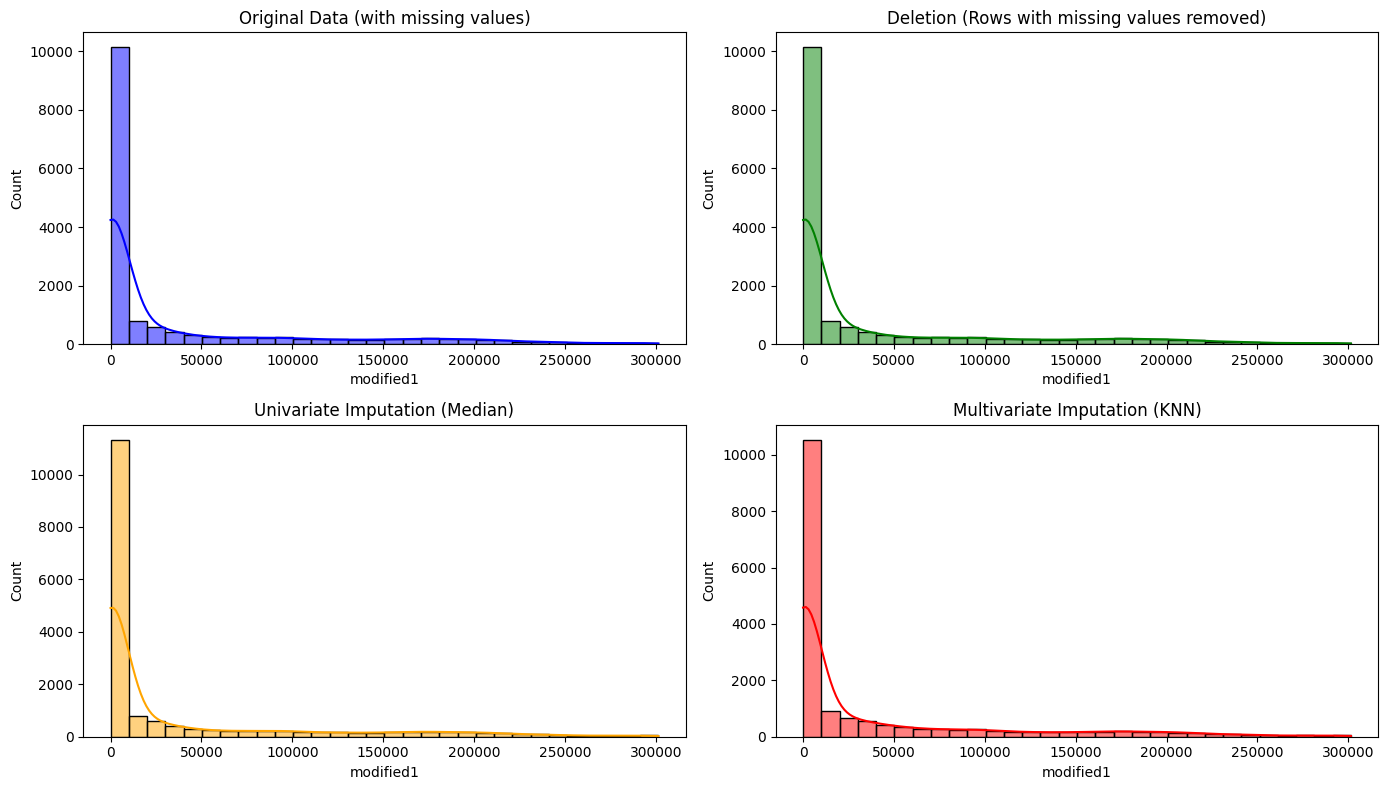

In [ ]:
# %%

# Visualize the distribution of 'modified1' for each approach
plt.figure(figsize=(14, 8))

# Original data
plt.subplot(2, 2, 1)
sns.histplot(data['modified1'], bins=30, kde=True, color='blue')
plt.title("Original Data (with missing values)")

# Deletion approach
plt.subplot(2, 2, 2)
sns.histplot(data_deletion['modified1'], bins=30, kde=True, color='green')
plt.title("Deletion (Rows with missing values removed)")

# Univariate Imputation
plt.subplot(2, 2, 3)
sns.histplot(data_univariate['modified1'], bins=30, kde=True, color='orange')
plt.title("Univariate Imputation (Median)")

# Multivariate Imputation
plt.subplot(2, 2, 4)
sns.histplot(data_multivariate['modified1'], bins=30, kde=True, color='red')
plt.title("Multivariate Imputation (KNN)")

plt.tight_layout()
plt.show()

In [ ]:
# %%

# Evaluate the imputation quality
missing_indices = data[data['modified1'].isna()].index

# Initialize a dictionary to store metrics
metrics_on_missing = {}

# Univariate Imputation
mse_uni = mean_squared_error(
    data.loc[missing_indices, 'raw'],
    data_univariate.loc[missing_indices, 'modified1']
)
mae_uni = mean_absolute_error(
    data.loc[missing_indices, 'raw'],
    data_univariate.loc[missing_indices, 'modified1']
)
std_err_uni = np.std(
    data_univariate.loc[missing_indices, 'modified1'] -
    data.loc[missing_indices, 'raw']
) / np.sqrt(len(missing_indices))

metrics_on_missing['Univariate Imputation'] = {
    'MSE': mse_uni,
    'MAE': mae_uni,
    'Standard Error': std_err_uni
}

# Multivariate Imputation
mse_multi = mean_squared_error(
    data.loc[missing_indices, 'raw'],
    data_multivariate.loc[missing_indices, 'modified1']
)
mae_multi = mean_absolute_error(
    data.loc[missing_indices, 'raw'],
    data_multivariate.loc[missing_indices, 'modified1']
)
std_err_multi = np.std(
    data_multivariate.loc[missing_indices, 'modified1'] -
    data.loc[missing_indices, 'raw']
) / np.sqrt(len(missing_indices))

metrics_on_missing['Multivariate Imputation'] = {
    'MSE': mse_multi,
    'MAE': mae_multi,
    'Standard Error': std_err_multi
}

# Convert metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_on_missing).T
metrics_df.columns = [
    "Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "Standard Error"
]

metrics_df

,Mean Squared Error (MSE),Mean Absolute Error (MAE),Standard Error
Univariate Imputation,5.522092e+09,35595.197070,1890.156017
Multivariate Imputation,4.664911e+09,45406.445071,1978.625066


# %% [markdown]

 The table below compares each imputation method against the `raw` data as the reference baseline. The performance metrics used are:

 - **Mean Squared Error (MSE)**: Measures the average squared difference between imputed values and `raw` values. Lower values indicate better accuracy.
 - **Mean Absolute Error (MAE)**: Represents the average absolute difference between imputed and `raw` values. Lower values indicate better fit.
 - **Standard Error**: Assesses the variability of the difference between imputed values and `raw` values. Lower values suggest greater stability.

 | Imputation Method         | Mean Squared Error (MSE) | Mean Absolute Error (MAE) | Standard Error |
 |---------------------------|--------------------------|---------------------------|----------------|
 | **Univariate Imputation** | 5.522092e+09 | 35595.197070 | 1890.156017 |
 | **Multivariate Imputation** | 4.664911e+09 | 45406.445071 | 1978.625066 |

 - **Multivariate Imputation (KNN)** resulted in a lower MSE, suggesting better overall accuracy in capturing the variability of the data compared to **Univariate Imputation (Median)**.
 - However, **Univariate Imputation (Median)** achieved a lower MAE, indicating that on average, its imputed values were closer to the `raw` values.
 - The **Standard Error** was slightly lower for **Univariate Imputation**, indicating slightly less variability in the errors.

 In summary, both imputation methods have their merits. **Multivariate Imputation (KNN)** better captures the overall variability in the data (lower MSE), while **Univariate Imputation (Median)** provides imputed values that are closer on average to the `raw` values (lower MAE). Depending on the specific requirements of the analysis, one method may be preferred over the other.